## Implementing Deep Q-Learning with XOR/XNOR data

This notebook shows an experiment using rl-keras deep q-learning to classify XOR/XNOR data. It is adapted from Mordred Yuan's [notebook](https://github.com/NeuroDataDesign/ProgLearn_2021-2022/blob/main/Mordred_Yuan/Week%209/rl_classification.ipynb) testing the performance of deep q-qlearning on the CIFAR 10 dataset.

### Setup

Installing a Deep Reinforcement Learning for Tensorflow 2 Keras package.

In [1]:
!pip install -q git+https://github.com/wau/keras-rl2.git

Importing necessary libraries, as well as the XOR/XNOR generation functions from xor_xnor_functions.py.

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Activation,
    Embedding,
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import os
import gym
from gym import error, spaces
from gym import utils
from gym.utils import seeding
from sklearn.metrics import classification_report, confusion_matrix
import random
from multiprocessing import Pool
from functools import partial
from keras.layers import *
from keras.models import *
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations, product

from proglearn.sims import generate_gaussian_parity
import xor_xnor_functions as fn

import argparse, os
from PIL import Image
import keras.backend as K
from keras.backend import set_session
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

from random import sample

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Gym Setup

We're using Gym to simplify the training. Gym is a toolkit for working with reinforcement algorithms and allows an easy way to test deep q-learning algorithms. We are defining a custom Gym environment for classification here because there is not an included classification environment in Gym. [This](https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952) is a helpful article about custom Gym environments and how they are used.

In our custom environment, we define init, seed, step, my_metrics, and reset. 

- Init just defines the parameters the environment uses. Init is pretty straightforward, the most interesting part is the action space. In the XOR/XNOR dataset there are only 2 possible classes, so we set the action space to being 2 discrete classes. In teh CIFAR-10 dataset it would be 10.

- Seed is a function that is used if we want to reproduce experiments using random number generators. It's not used in the XOR/XNOR experiment.

- Step is the function that takes an action in the q-learning algorithm. This function defines the behavior at each time step and adjusts the q-matrix according to if the sample is correctly identified. We set the reward to 1, and the punishment to -1. It also adds the g-mean and f-measure to metrics at the end of each training run.

- My_metrics calculates various metrics for a run. The metrics we are interested in are precision, recall, accuracy, g-mean, and f-measure. In addition, this function prints out these metrics for each run, as well as an overall confusion matrix, g-mean, and f-measure. 

- Reset simply resets the environment to zero so that it can be used to train again.

In [3]:
class ClassifyEnv(gym.Env):
    def __init__(self, mode, trainx, trainy):  # mode means training or testing
        self.mode = mode

        self.Env_data = trainx
        # print(type(self.Env_data))
        self.Answer = trainy
        self.id = np.arange(trainx.shape[0])
        # print(self.id)

        self.game_len = self.Env_data.shape[0]

        self.num_classes = 2
        self.action_space = spaces.Discrete(self.num_classes)
        # print(self.action_space)
        self.step_ind = 0
        self.y_pred = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, a):
        self.y_pred.append(a)
        y_true_cur = []
        info = {}
        terminal = False
        if a == self.Answer[self.id[self.step_ind]]:
            reward = 1.0
        else:
            reward = -1.0
            if self.mode == "train":
                terminal = True
        self.step_ind += 1

        if self.step_ind == self.game_len - 1:
            y_true_cur = self.Answer[self.id]
            info["gmean"], info["fmeasure"] = self.My_metrics(
                np.array(self.y_pred), np.array(y_true_cur[: self.step_ind])
            )
            terminal = True

        return self.Env_data[self.id[self.step_ind]], reward, terminal, info

    def My_metrics(self, y_pre, y_true):
        confusion_mat = confusion_matrix(y_true, y_pre)
        print("\n")
        print(classification_report(y_true, y_pre))
        conM = np.array(confusion_mat, dtype="float")
        TP = conM[1][1]
        TN = conM[0][0]
        FN = conM[1][0]
        FP = conM[0][1]
        TPrate = TP / (TP + FN)
        TNrate = TN / (TN + FP)
        FPrate = FP / (TN + FP)
        FNrate = FN / (TP + FN)
        PPvalue = TP / (TP + FP)
        NPvalue = TN / (TN + FN)

        G_mean = np.sqrt(TPrate * TNrate)

        Recall = TPrate = TP / (TP + FN)
        Precision = PPvalue = TP / (TP + FP)
        F_measure = 2 * Recall * Precision / (Recall + Precision)
        print(confusion_mat)
        res = "G-mean:{}, F_measure:{}\n".format(G_mean, F_measure)
        print(res)
        print()
        return G_mean, F_measure

    # return: (states, observations)
    def reset(self):
        if self.mode == "train":
            np.random.shuffle(self.id)
        self.step_ind = 0
        self.y_pred = []
        return self.Env_data[self.id[self.step_ind]]

### Model setup

This defines the network that wil be trained.

In [4]:
def get_image_model(in_shape, output):
    model = Sequential()
    model.add(Dense(500, activation="relu", input_dim=2))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    return model

### Processor Function

In [5]:
class ClassifyProcessor(Processor):
    def process_observation(self, observation):
        img = observation.reshape(INPUT_SHAPE)
        processed_observation = np.array(img)
        return processed_observation

    def process_state_batch(self, batch):
        batch = batch.reshape((-1,) + INPUT_SHAPE)
        processed_batch = batch.astype("float32") / 1.0
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)

### XOR/XNOR Setup

Get_xor_data and get_xnor_data generate the XOR/XNOR data for the experiment using the functions in xor_xnor_functions.py

In [6]:
def get_xor_data():
    X_xor, y_xor = generate_gaussian_parity(1000)
    fn.plot_xor_xnor(X_xor, y_xor, "Gaussian XOR")

    return X_xor, y_xor

In [7]:
def get_xnor_data():
    X_xnor, y_xnor = generate_gaussian_parity(1000, angle_params=np.pi / 2)
    fn.plot_xor_xnor(X_xnor, y_xnor, "Gaussian XNOR")

    return X_xnor, y_xnor

This function is used to divide the XOR/XNOR data into training and testing sets. Input training percentage as a decimal, e.g. .8 for 80% training. 

In [8]:
def divide_train_test(X, Y, train_percentage):
    test_percentage = 1 - train_percentage

    len_train = int(train_percentage * len(X))
    len_test = len(X) - len_train

    full_indices = []
    for i in range(len(X)):
        full_indices.append(i)

    train_indices = set(sample(full_indices, len_train))
    test_indices = set(full_indices) - train_indices

    X_train_subset = []
    for trix in train_indices:
        X_train_subset.append(X[trix])

    X_test_subset = []
    for teix in test_indices:
        X_test_subset.append(X[teix])

    Y_train_subset = []
    for triy in train_indices:
        Y_train_subset.append(Y[triy])

    Y_test_subset = []
    for teiy in test_indices:
        Y_test_subset.append(Y[teiy])

    return (
        np.array(X_train_subset),
        np.array(X_test_subset),
        np.array(Y_train_subset),
        np.array(Y_test_subset),
    )

### Function to run either XOR or XNOR

Use this function to train on a set of data. To run XOR, specify 'xor'. To run XNOR, specify 'xnor'. The default is 'xor'. You may also specify the percentage separated into training. The default is a 70-30 training testing split.

In [17]:
def run_training(x_train, x_test, y_train, y_test):
    # Generate data

    in_shape = x_train.shape[1:]
    num_classes = 2
    mode = "train"
    env = ClassifyEnv(mode, x_train, y_train)
    nb_actions = num_classes
    training_steps = 120000
    model = get_image_model(in_shape, num_classes)

    INPUT_SHAPE = in_shape
    # print(num_classes)
    print(model.summary())

    memory = SequentialMemory(limit=100000, window_length=1)
    processor = ClassifyProcessor()
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr="eps",
        value_max=1.0,
        value_min=0.1,
        value_test=0.05,
        nb_steps=100000,
    )
    dqn = DQNAgent(
        model=model,
        nb_actions=2,
        policy=policy,
        memory=memory,
        processor=processor,
        nb_steps_warmup=50000,
        gamma=0.5,
        target_model_update=10000,
        train_interval=4,
        delta_clip=1.0,
    )
    dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])

    dqn.fit(env, nb_steps=training_steps, log_interval=60000)

    env.mode = "test"
    dqn.test(env, nb_episodes=2, visualize=False)
    env = ClassifyEnv(mode, x_test, y_test)
    env.mode = "test"
    dqn.test(env, nb_episodes=2, visualize=False)

Train model with just xor and just xnor. It outputs the performance of the model, as well as a confusion matrix.

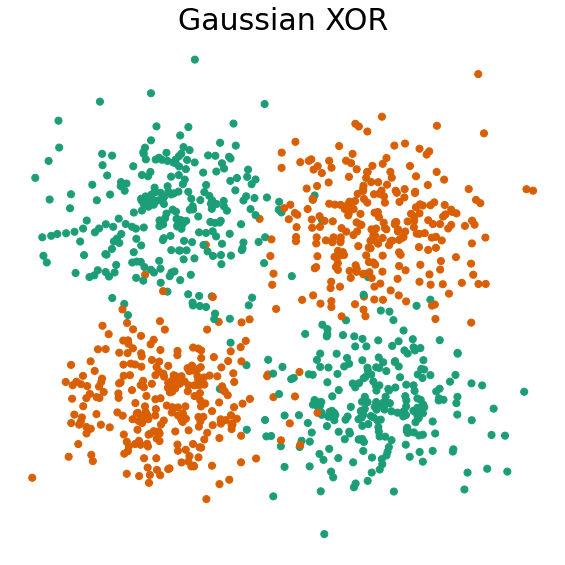

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 500)               1500      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total params: 56,752
Trainable params: 56,752
Non-trainable params: 0
_________________________________________________________________
None
Training for 120000 steps ...
Interval 1 (0 steps performed)
    1/60000 [..............................] - ETA: 3:01:42 - reward: 1.0000

c:\users\sarah\documents\sarah\neuro data design\q-learning\qlearning\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 147s 2ms/step - reward: 0.1712 : 2:14 - reward: 0. - ETA: 1:55 - ETA: 1:47 - rewa - ETA: 1:44 - reward: 0. - ETA: 1:4 - ETA: 1:42 - reward:  - ETA: 1:42 - reward:  - ETA: 1:4 - ETA: 1: - ETA: 1:40 - reward: 0. - ETA: 1:39 - reward - ETA: 1:3 - ETA: 1:37 - reward: 0. - ETA: 1:37 - reward: - ETA: 1:37 - reward: 0. - ETA:  - ETA: 1:35 - reward: 0. - ETA: 1:34 - re  - ETA: 1:32 - reward: - E - ETA: 1:30  - ETA: 1:29 - rewar - ETA: 1:28 - rewa - ETA: 1:27 - reward: 0.032 - ETA: 1:27 - reward - ETA: 1:27 - re - ETA: 1:26 - reward: 0.0 - ETA - ETA: 1:25 - reward - ETA: 1:25 - reward: 0.03 - ETA: 1
24865 episodes - episode_reward: 0.413 [-1.000, 23.000] - loss: 0.269 - mae: 0.523 - mean_q: 0.976 - mean_eps: 0.505

Interval 2 (60000 steps performed)
60000/60000 [==============================] - 361s 6ms/step - reward: 0.7375
done, took 507.879 seconds
Testing for 2 episodes ...


              precision    recall  f1-score   support

           0 

In [18]:
x_xor, y_xor = get_xor_data()
x_train_xor, x_test_xor, y_train_xor, y_test_xor = divide_train_test(x_xor, y_xor, 0.7)
INPUT_SHAPE = x_train_xor.shape[1:]
run_training(x_train_xor, x_test_xor, y_train_xor, y_test_xor)

The XOR data was able to achieve a geometric mean score of .97 and .95 on the first and second test runs respectively. 

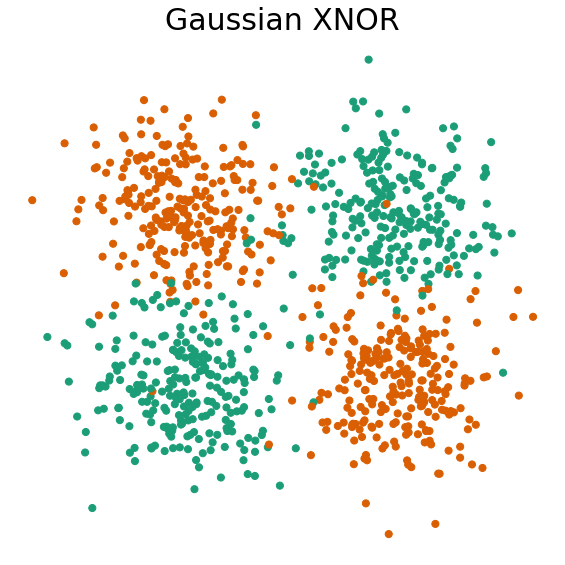

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 102       
Total params: 56,752
Trainable params: 56,752
Non-trainable params: 0
_________________________________________________________________
None
Training for 120000 steps ...
Interval 1 (0 steps performed)
   27/60000 [..............................] - ETA: 1:55 - reward: 0.2593   

c:\users\sarah\documents\sarah\neuro data design\q-learning\qlearning\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 186s 3ms/step - reward: 0.0177
29468 episodes - episode_reward: 0.036 [-1.000, 23.000] - loss: 0.311 - mae: 0.599 - mean_q: 0.976 - mean_eps: 0.505

Interval 2 (60000 steps performed)
60000/60000 [==============================] - 338s 6ms/step - reward: 0.7323
done, took 524.327 seconds
Testing for 2 episodes ...


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       343
           1       0.96      0.98      0.97       356

    accuracy                           0.97       699
   macro avg       0.97      0.97      0.97       699
weighted avg       0.97      0.97      0.97       699

[[330  13]
 [  8 348]]
G-mean:0.9697829243186653, F_measure:0.9707112970711296


Episode 1: reward: 657.000, steps: 699


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       343
           1       0.96      0.98      0.97       356

    accuracy          

In [19]:
x_xnor, y_xnor = get_xnor_data()
x_train_xnor, x_test_xnor, y_train_xnor, y_test_xnor = divide_train_test(
    x_xnor, y_xnor, 0.7
)
INPUT_SHAPE = x_train_xnor.shape[1:]
run_training(x_train_xnor, x_test_xnor, y_train_xnor, y_test_xnor)

The XNOR data was able to achieve a geometric mean score of 0.96 on both runs.

The model achieved more than 95% accuracy on both XOR and XNOR. This is far better than the chance accuracy for this problem of 50%. It seems to imply that q-learning would be a good approach for the XOR/XNOR dataset.